# 1. Исследование данных

                     num_orders
datetime                       
2018-03-01 00:00:00           9
2018-03-01 00:10:00          14
2018-03-01 00:20:00          28
2018-03-01 00:30:00          20
2018-03-01 00:40:00          32
True
                     num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43


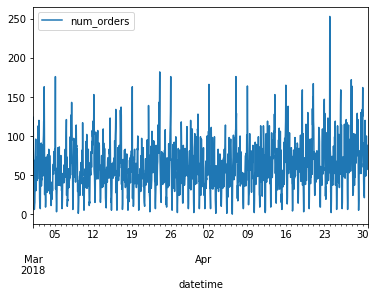

In [13]:
import pandas as pd
data = pd.read_csv('../Taxi/taxi.csv', parse_dates=[0], index_col='datetime')
print(data.head())
print(data.index.is_monotonic)
data = data.resample('1H').sum()
print(data.head())
data['2018-03':'2018-04'].plot()

Загрузим данные и ресэмплируем их по одному часу. По графику для всего массива данных что-то понять сложно.

Text(0.5, 1.0, 'Сезонность за полмесяца')

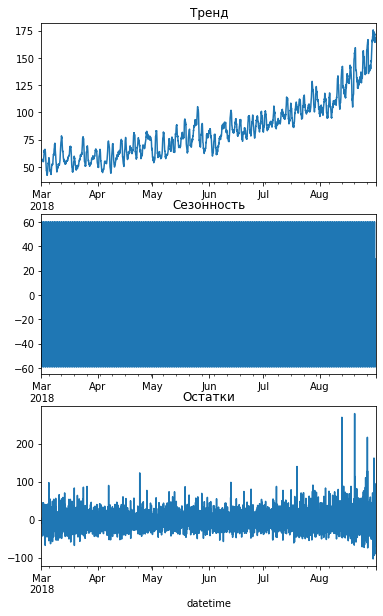

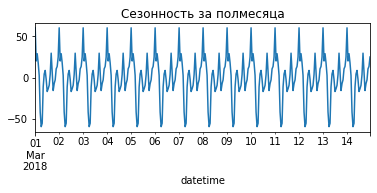

In [14]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(data)
plt.figure(figsize=(6, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остатки')

plt.figure(figsize=(6, 2))
decomposed.seasonal['2018-03-01':'2018-03-14'].plot(ax=plt.gca())
plt.title('Сезонность за полмесяца')

Выделим в данных сезонную, трендовую и остаточную составляющие. Виден восходящий тренд, следовательно, ряд нельзя отнести к стационарным, т.к. его среднее значение меняется. Для того, чтобы выявить сезонность, построим график среза данных за полмесяца. Теперь отчётливо видна суточная сезонность.

# 2. Обучение моделей

In [15]:
data['month'] = data.index.month
data['day'] = data.index.day
data['dayofweek'] = data.index.dayofweek
data['rolling_mean'] = data['num_orders'].shift(24).rolling(5).mean()
for i in range(1,5):
    data['lag_{}'.format(i)] = data['num_orders'].shift(i)

Добавим столбцы с месяцем, днём, днём недели и скользящим средним (пока что возьмём размер окна равный 5). Исходя из того, что мы будем строить краткосрочный прогноз по часам, добавим 4 столбца со сдвигом данных на 1, 2, 3 и 4 часа. Так как присутствует суточная сезонность, посчитаем скользящее среднее со сдвигом на 24 часа.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import LinearRegression

def split_data(df):
    """
    Делит выборку на тренировочную, валидационную и тестовую
    """
    trainvalid, test = train_test_split(df, shuffle=False, test_size=0.1)
    train, valid = train_test_split(trainvalid, shuffle=False, test_size=0.1)
    
    train = train.dropna()
    
    target_test = test['num_orders']
    features_test = test.drop(['num_orders'], axis='columns')
    target_train = train['num_orders']
    features_train = train.drop(['num_orders'], axis='columns')
    target_valid = valid['num_orders']
    features_valid = valid.drop(['num_orders'], axis='columns')
    
    return target_test,features_test,target_train,features_train,target_valid,features_valid
    
target_test,features_test,target_train,features_train,target_valid,features_valid = split_data(data)

print(features_train.index.min(), features_train.index.max())
print(features_valid.index.min(), features_valid.index.max())
print(features_test.index.min(), features_test.index.max())

2018-03-02 04:00:00 2018-07-27 23:00:00
2018-07-28 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


Разделим выборку на тренировочную, валидационную и тестовую. Проверка показывает, что они разделены последовательно по времени. Проверим несколько моделей. Для решающего дерева и случайного леса также подберём гиперпараметры (максимальная глубина и число деревьев).

In [17]:
model = LinearRegression()
model.fit(features_train,target_train)
valid_predictions = model.predict(features_valid)
print("RMSE линейной регрессии:", mse(target_valid,valid_predictions)**0.5)

RMSE линейной регрессии: 39.968982203547


In [18]:
from sklearn.tree import DecisionTreeRegressor
print("Для решающего дерева:")

for i in range(3,10,1):
    model = DecisionTreeRegressor(max_depth=i,random_state=1)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print("При max_depth={}".format(i), "rmse={}".format(mse(target_valid, predicted_valid)**0.5))

Для решающего дерева:
При max_depth=3 rmse=45.057850362046196
При max_depth=4 rmse=44.94711634844403
При max_depth=5 rmse=44.279062990219735
При max_depth=6 rmse=45.47127066743261
При max_depth=7 rmse=46.00960037631453
При max_depth=8 rmse=46.49693693168091
При max_depth=9 rmse=48.34534675945342


In [19]:
from sklearn.ensemble import RandomForestRegressor
print("Для случайного леса:")

for i in range(10,51,10):
    model = RandomForestRegressor(max_depth=4, n_estimators=i,random_state=1)
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    print("При n_estimators={}".format(i), "rmse={}".format(mse(target_valid, predicted_valid)**0.5))

Для случайного леса:
При n_estimators=10 rmse=43.729240535913334
При n_estimators=20 rmse=43.45546537252888
При n_estimators=30 rmse=43.60462998066974
При n_estimators=40 rmse=43.61980672928222
При n_estimators=50 rmse=43.55068998583509


Перебор различных моделей показывает, что самое низкое RMSE = 39.97 дает линейная регрессия. Попробуем уменьшить это значение ещё сильнее, меняя размер окна и сдвиг для скользящего среднего, перебрав эти параметры в цикле.

In [20]:
arr_rmse = []
arr_ik = []
for i in range (5,14,2): #i это размер окна
    for k in range(1,24,2): #k это величина сдвига для окна
        data['rolling_mean'] = data['num_orders'].shift(k).rolling(i).mean()
        target_test,features_test,target_train,features_train,target_valid,features_valid = split_data(data)
        model = LinearRegression()
        model.fit(features_train,target_train)
        valid_predictions = model.predict(features_valid)
        arr_rmse.append(mse(target_valid,valid_predictions)**0.5)
        arr_ik.append((i,k))

min_rmse = min(arr_rmse)
min_parameters = arr_ik[arr_rmse.index(min_rmse)]
print('Минимальный rmse {}'.format(min_rmse), 'для размера окна {}'.format(min_parameters[0]),
      'и сдвига нa {}'.format(min_parameters[1]))

Минимальный rmse 37.73193308880901 для размера окна 5 и сдвига нa 21


Таким образом, оптимальной моделью является линейная регрессия, при этом в данные необходимо добавить столбец со значением скользящего среднего, вычисленного со сдвигом 21 и размером окна 5.

In [21]:
data['rolling_mean'] = data['num_orders'].shift(21).rolling(5).mean()

target_test,features_test,target_train,features_train,target_valid,features_valid = split_data(data)

# 3. Тестирование моделей

In [22]:
features_trainvalid = pd.concat([features_train,features_valid])
target_trainvalid = pd.concat([target_train,target_valid])
model = LinearRegression()
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
print("rmse={}".format(mse(target_test, predicted_test)**0.5))

rmse=47.18742529223929


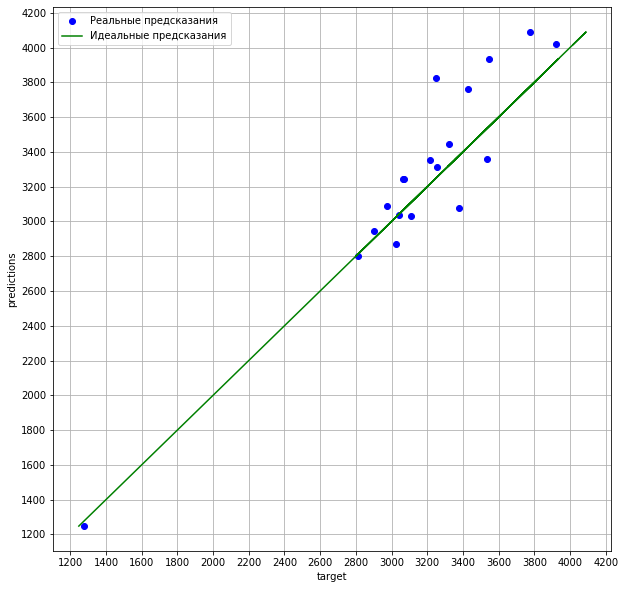

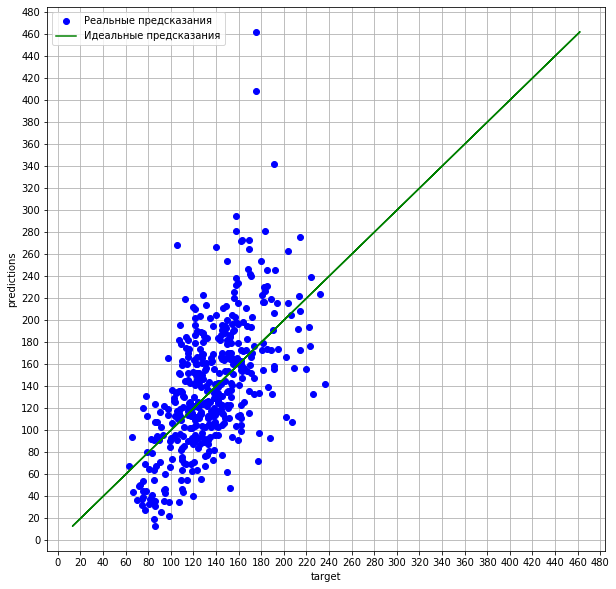

In [23]:
final_data = pd.DataFrame({'predictions': predicted_test,'target':target_test.values},index=target_test.index)
final_data_days = final_data.resample('1D').sum()
final_data_hours = final_data.resample('1H').sum()

import matplotlib.ticker as ticker

fig, ax = plt.subplots()
ax.plot(final_data_days['predictions'],final_data_days['target'],'bo')
ax.plot(final_data_days['target'],final_data_days['target'],'g-')
ax.legend(['Реальные предсказания','Идеальные предсказания'])
ax.set_xlabel('target')
ax.set_ylabel('predictions')
ax.xaxis.set_major_locator(ticker.MultipleLocator(200))
ax.yaxis.set_major_locator(ticker.MultipleLocator(200))
ax.grid()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.show()

fig, ax = plt.subplots()
ax.plot(final_data_hours['predictions'],final_data_hours['target'],'bo')
ax.plot(final_data_hours['target'],final_data_hours['target'],'g-')
ax.legend(['Реальные предсказания','Идеальные предсказания'])
ax.set_xlabel('target')
ax.set_ylabel('predictions')
ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
ax.grid()
fig.set_figwidth(10)
fig.set_figheight(10)
plt.show()

Метод линейной регрессии, обученной на объединённых валидационной и тренировочной выборках, на тестовой выборке даёт величину rmse = 47.32. Построим график зависимости предсказанных значений от реальных значений для дневных и для часовых предсказаний.  Видно, что модель лучше предсказывает спрос по дням, чем по часам. Кроме того, в обоих случаях чем выше реальное значение, тем чаще модель завышает предсказания.

## Общий вывод

Удалось достичь требуемого значения метрики качества (rmse = 47.19), используя метод линейной регрессии. Однако следует применять её с осторожностью, так как она склонна завышать предсказанное количество значений относительно реальных, кроме того, она больше подходит для дневных предсказаний, а не для часовых.